<hr style="height:2px;">

# Deep learning based Ion beam tomography (Deep IBT)

This notebook demonstrates training data generation for a 3D → 2D denoising+projection task, where corresponding pairs of low and high quality 3D stacks can be acquired. The surface of interest is then extracted from the high quality stacks with a conventional projection method, such as [PreMosa](https://doi.org/10.1093/bioinformatics/btx195).

More documentation is available at http://csbdeep.bioimagecomputing.com/doc/.

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from csbdeep.utils import download_and_extract_zip_file, plot_some
from csbdeep.data import RawData, create_patches_reduced_target

<hr style="height:2px;">

# STEP1: DATA GENERATION, Load organized ion beam data (raw stack and SILM single slice)

First we download some example data, consisting of low-SNR 3D stacks with corresponding 2D surface images extracted from the high-SNR stacks.  
Note that `GT` stands for [ground truth](https://en.wikipedia.org/wiki/Ground_truth) and represents high signal-to-noise ratio (SNR) images.

We can plot one of the training pairs:

In [2]:
#y = imread('data/retinasr/s5-c05long-31slices-si.tif')
#x = imread('data/retina/s5-c05long-31slices-si.tif')

y = imread('data/retinasr/imiducell.tif')
x = imread('data/retina/imiducell.tif')

print('input  image size =', x.shape)
print('output image size =', y.shape)




input  image size = (21, 768, 768)
output image size = (768, 768)


<hr style="height:2px;">

# Generate training data for denoising + projection CARE

We first need to create a `RawData` object, which defines how to get the pairs of low/high SNR images and the semantics of each axis (e.g. which one is considered a color channel, etc.).

Here we have several folders with low-SNR images and one folder "GT" with the high-SNR extracted surface images. Note that corresponding images are TIFF files with identical names.  
For this case, we use `RawData.from_folder` and set `axes = 'ZYX'` to indicate the semantic axes of the low-SNR input stacks.

In [3]:
raw_data = RawData.from_folder (
    basepath    = 'data',
    source_dirs = ['retina'],
    target_dir  = 'retinasr',
    axes        = 'ZYX',
)

From corresponding images, we now generate some 3D/2D patches. As a general rule, use a `patch_size` that is a power of two along all non-channel axes, here at least divisible by 16. You can use `None` along the projection axis (typically `Z`, i.e. use `reduction_axes = 'Z'`) to indicate that each patch should contain the entire image along this axis.
Furthermore, set `target_axes` appropriately if the target images are missing the projection axis.

Note that returned values `(X, Y, XY_axes)` by `create_patches_reduced_target` are not to be confused with the image axes X and Y.  
By convention, the variable name `X` (or `x`) refers to an input variable for a machine learning model, whereas `Y` (or `y`) indicates an output variable.

In [4]:
X, Y, XY_axes = create_patches_reduced_target (
    raw_data            = raw_data,
    patch_size          = (None,48,48),
    n_patches_per_image = 100,
    target_axes         = 'YX',
    reduction_axes      = 'Z',
    save_file           = 'data/my_training_data.npz',
)

    1 raw images x    1 transformations   =     1 images
    1 images     x  100 patches per image =   100 patches in total
Input data:
data: target='retinasr', sources=['retina'], axes='ZYX', pattern='*.tif*'
Transformations:
1 x Broadcast target image to the shape of source
Patch size:
21 x 48 x 48


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.26s/it]


Saving data to data\my_training_data.npz.


In [5]:
print("shape of X   =", X.shape)
print("shape of Y   =", Y.shape)
print("axes  of X,Y =", XY_axes)

shape of X   = (100, 1, 21, 48, 48)
shape of Y   = (100, 1, 1, 48, 48)
axes  of X,Y = SCZYX


## Show

This shows some of the generated patch pairs (even rows: maximum projection of *source*, odd rows: *target*)

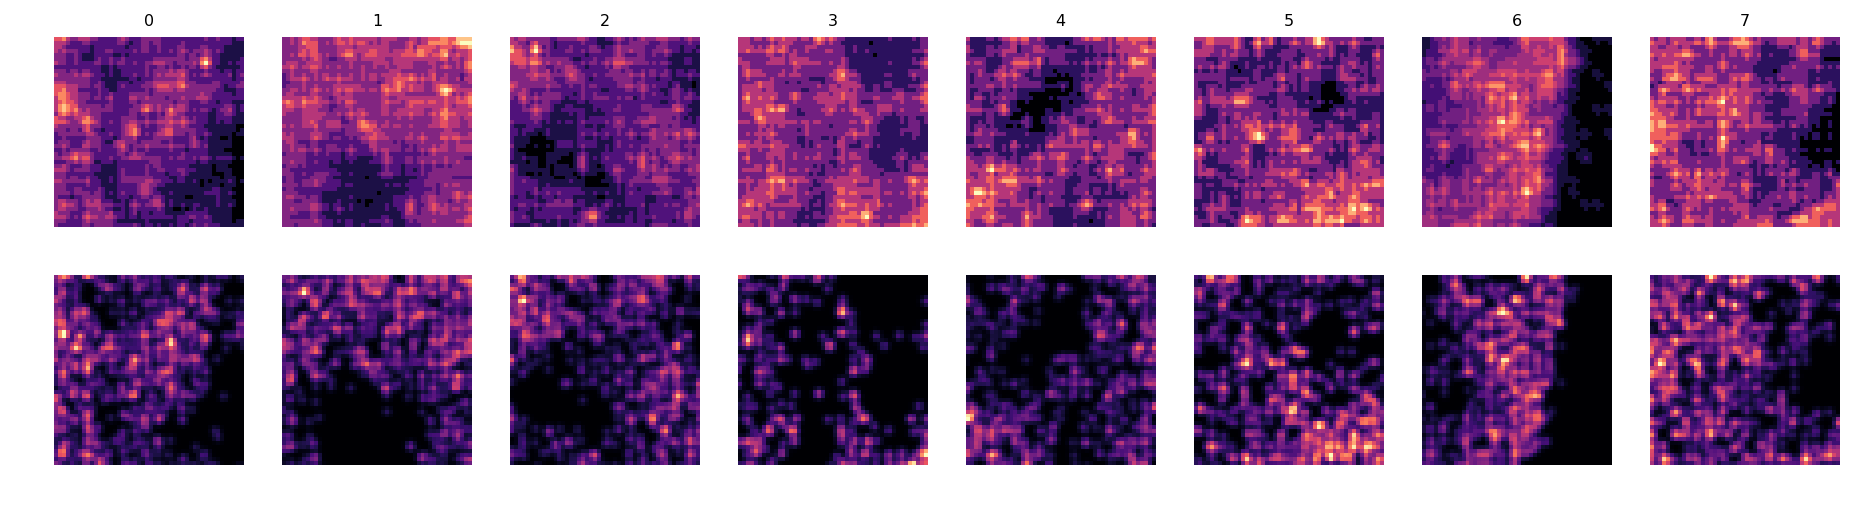

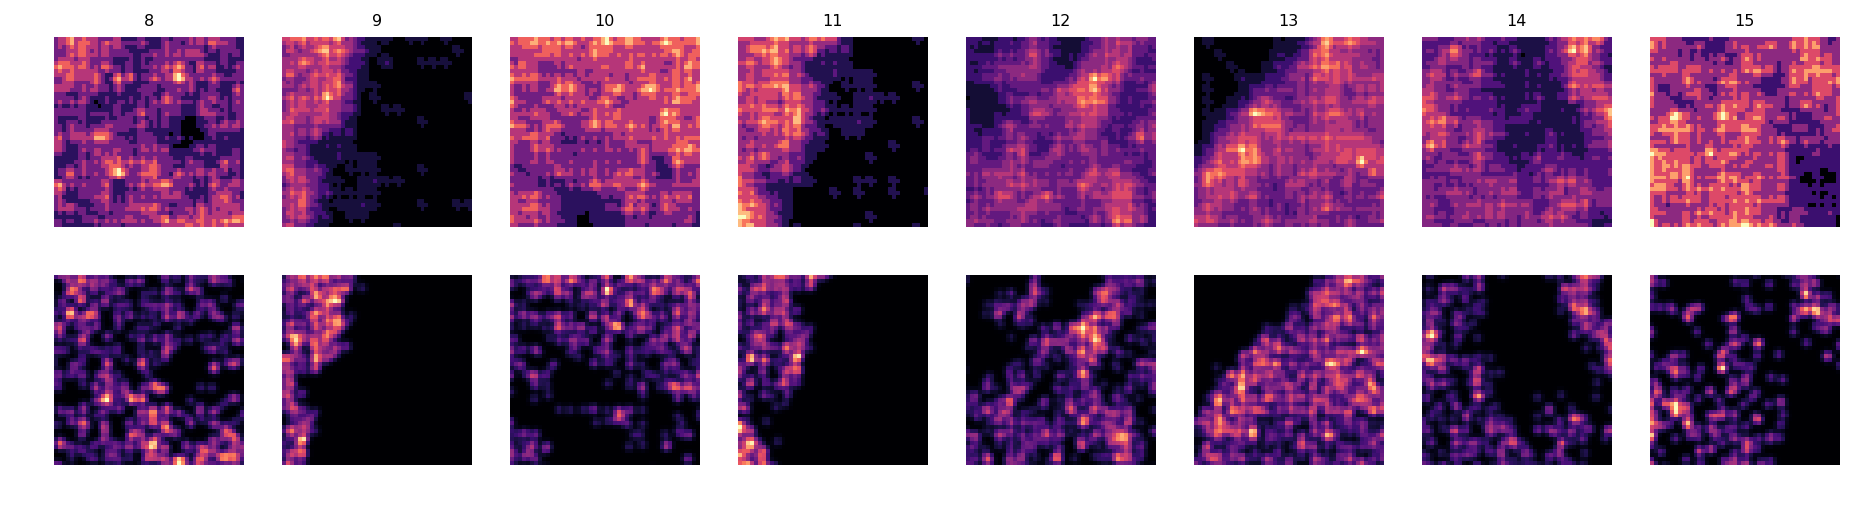

In [6]:
for i in range(2):
    plt.figure(figsize=(16,4))
    sl = slice(8*i, 8*(i+1)), 0
    plot_some(X[sl],Y[sl],title_list=[np.arange(sl[0].start,sl[0].stop)])
    plt.show()
None;

<hr style="height:2px;">

# STEP 2: TRAINING AND MODEL EXPORT

We first need to create a `RawData` object, which defines how to get the pairs of low/high SNR images and the semantics of each axis (e.g. which one is considered a color channel, etc.).


In [7]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tensorflow.python.keras import backend

from tifffile import imread
from csbdeep.utils import axes_dict, plot_some, plot_history
from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.io import load_training_data
from csbdeep.models import Config, ProjectionCARE

Using TensorFlow backend.


In [8]:
(X,Y), (X_val,Y_val), axes = load_training_data('data/my_training_data.npz', validation_split=0.1, verbose=True)

c = axes_dict(axes)['C']
n_channel_in, n_channel_out = X.shape[c], Y.shape[c]

number of training images:	 90
number of validation images:	 10
image size (3D):		 (21, 48, 48)
axes:				 SZYXC
channels in / out:		 1 / 1


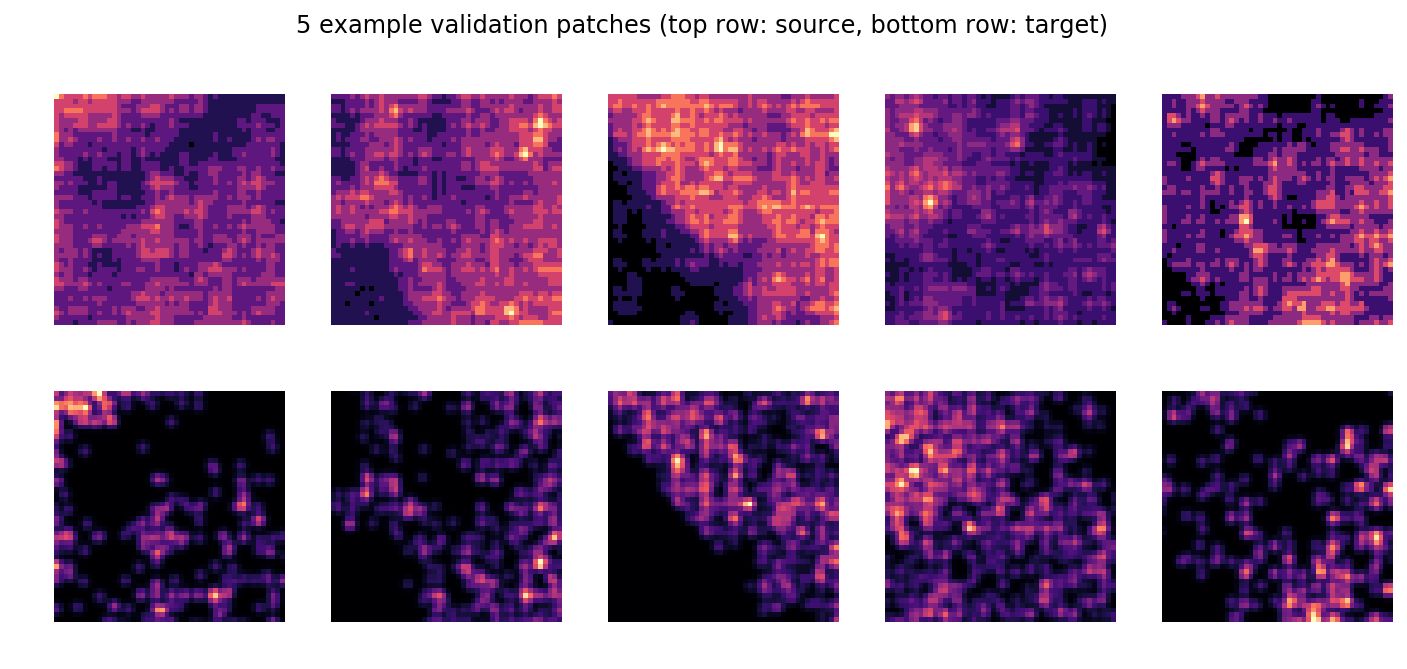

In [9]:
plt.figure(figsize=(12,5))
plot_some(X_val[:5],Y_val[:5])
plt.suptitle('5 example validation patches (top row: source, bottom row: target)');

In [10]:
config = Config(axes, n_channel_in, n_channel_out, unet_n_depth=3, train_batch_size=8, train_steps_per_epoch=20)
print(config)
vars(config)

Config(axes='ZYXC', n_channel_in=1, n_channel_out=1, n_dim=3, probabilistic=False, train_batch_size=8, train_checkpoint='weights_best.h5', train_epochs=100, train_learning_rate=0.0004, train_loss='mae', train_reduce_lr={'factor': 0.5, 'patience': 10, 'min_delta': 0}, train_steps_per_epoch=20, train_tensorboard=True, unet_input_shape=(None, None, None, 1), unet_kern_size=3, unet_last_activation='linear', unet_n_depth=3, unet_n_first=32, unet_residual=True)


{'n_dim': 3,
 'axes': 'ZYXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'probabilistic': False,
 'unet_residual': True,
 'unet_n_depth': 3,
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, None, 1),
 'train_loss': 'mae',
 'train_epochs': 100,
 'train_steps_per_epoch': 20,
 'train_learning_rate': 0.0004,
 'train_batch_size': 8,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10, 'min_delta': 0}}

In [11]:
model = ProjectionCARE(config, 'my_model', basedir='models')

C:\ProgramData\Anaconda3\lib\site-packages\csbdeep\models\care_standard.py:139: UserWarning: output path for model already exists, files may be overwritten: C:\Users\Administrator\Documents\REVORGDATA\paper\extractionScripts\deeplearn_analysis\projection\models\my_model
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


Instructions for updating:
Colocations handled automatically by placer.


In [12]:
model.proj_params

ProjectionParameters(axis='Z', n_depth=4, n_filt=8, n_conv_per_depth=1, kern=(3, 3, 3), pool=(1, 2, 2))

In [13]:
import tensorflow as tf

hello = tf.constant('Hello, TensorFlow!')
sess = tf.Session()
print(sess.run(hello))

b'Hello, TensorFlow!'


In [14]:
history = model.train(X,Y, validation_data=(X_val,Y_val))

Instructions for updating:
Use tf.cast instead.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
20/20 [==============================] - ETA: 1:03 - loss: 0.1099 - mse: 0.0193 - mae: 0.109 - ETA: 1:04 - loss: 0.1136 - mse: 0.0205 - mae: 0.113 - ETA: 1:03 - loss: 0.1117 - mse: 0.0217 - mae: 0.111 - ETA: 59s - loss: 0.1119 - mse: 0.0222 - mae: 0.111 - ETA: 56s - loss: 0.1103 - mse: 0.0227 - mae: 0.11 - ETA: 53s - loss: 0.1073 - mse: 0.0221 - mae: 0.10 - ETA: 49s - loss: 0.1064 - mse: 0.0218 - mae: 0.10 - ETA: 45s - loss: 0.1065 - mse: 0.0217 - mae: 0.10 - ETA: 41s - loss: 0.1064 - mse: 0.0217 - mae: 0.10 - ETA: 38s - loss: 0.1063 - mse: 0.0218 - mae: 0.10 - ETA: 34s - loss: 0.1049 - mse: 0.0213 - mae: 0.10 - ETA: 30s - loss: 0.1049 - mse: 0.021

20/20 [==============================] - ETA: 1:10 - loss: 0.0826 - mse: 0.0149 - mae: 0.082 - ETA: 1:06 - loss: 0.0803 - mse: 0.0149 - mae: 0.080 - ETA: 1:03 - loss: 0.0768 - mse: 0.0140 - mae: 0.076 - ETA: 52s - loss: 0.0813 - mse: 0.0151 - mae: 0.081 - ETA: 50s - loss: 0.0790 - mse: 0.0143 - mae: 0.07 - ETA: 44s - loss: 0.0774 - mse: 0.0140 - mae: 0.07 - ETA: 41s - loss: 0.0783 - mse: 0.0141 - mae: 0.07 - ETA: 39s - loss: 0.0789 - mse: 0.0144 - mae: 0.07 - ETA: 36s - loss: 0.0796 - mse: 0.0145 - mae: 0.07 - ETA: 34s - loss: 0.0789 - mse: 0.0144 - mae: 0.07 - ETA: 30s - loss: 0.0797 - mse: 0.0145 - mae: 0.07 - ETA: 27s - loss: 0.0791 - mse: 0.0143 - mae: 0.07 - ETA: 24s - loss: 0.0789 - mse: 0.0142 - mae: 0.07 - ETA: 20s - loss: 0.0789 - mse: 0.0141 - mae: 0.07 - ETA: 17s - loss: 0.0803 - mse: 0.0145 - mae: 0.08 - ETA: 14s - loss: 0.0802 - mse: 0.0146 - mae: 0.08 - ETA: 10s - loss: 0.0799 - mse: 0.0145 - mae: 0.07 - ETA: 7s - loss: 0.0794 - mse: 0.0143 - mae: 0.0794 - ETA: 3s - loss:

20/20 [==============================] - ETA: 1:08 - loss: 0.0754 - mse: 0.0124 - mae: 0.075 - ETA: 1:05 - loss: 0.0661 - mse: 0.0101 - mae: 0.066 - ETA: 1:01 - loss: 0.0640 - mse: 0.0097 - mae: 0.064 - ETA: 59s - loss: 0.0629 - mse: 0.0094 - mae: 0.062 - ETA: 55s - loss: 0.0617 - mse: 0.0091 - mae: 0.06 - ETA: 51s - loss: 0.0626 - mse: 0.0092 - mae: 0.06 - ETA: 48s - loss: 0.0648 - mse: 0.0097 - mae: 0.06 - ETA: 41s - loss: 0.0669 - mse: 0.0102 - mae: 0.06 - ETA: 38s - loss: 0.0661 - mse: 0.0100 - mae: 0.06 - ETA: 35s - loss: 0.0651 - mse: 0.0099 - mae: 0.06 - ETA: 31s - loss: 0.0658 - mse: 0.0100 - mae: 0.06 - ETA: 28s - loss: 0.0663 - mse: 0.0101 - mae: 0.06 - ETA: 24s - loss: 0.0661 - mse: 0.0101 - mae: 0.06 - ETA: 21s - loss: 0.0663 - mse: 0.0102 - mae: 0.06 - ETA: 18s - loss: 0.0667 - mse: 0.0102 - mae: 0.06 - ETA: 14s - loss: 0.0665 - mse: 0.0102 - mae: 0.06 - ETA: 10s - loss: 0.0660 - mse: 0.0100 - mae: 0.06 - ETA: 7s - loss: 0.0656 - mse: 0.0100 - mae: 0.0656 - ETA: 3s - loss:

Epoch 35/100
20/20 [==============================] - ETA: 1:07 - loss: 0.0418 - mse: 0.0053 - mae: 0.041 - ETA: 1:04 - loss: 0.0506 - mse: 0.0067 - mae: 0.050 - ETA: 1:02 - loss: 0.0509 - mse: 0.0066 - mae: 0.050 - ETA: 58s - loss: 0.0526 - mse: 0.0068 - mae: 0.052 - ETA: 54s - loss: 0.0525 - mse: 0.0067 - mae: 0.05 - ETA: 51s - loss: 0.0524 - mse: 0.0067 - mae: 0.05 - ETA: 48s - loss: 0.0520 - mse: 0.0066 - mae: 0.05 - ETA: 44s - loss: 0.0521 - mse: 0.0067 - mae: 0.05 - ETA: 38s - loss: 0.0504 - mse: 0.0064 - mae: 0.05 - ETA: 35s - loss: 0.0510 - mse: 0.0065 - mae: 0.05 - ETA: 31s - loss: 0.0516 - mse: 0.0065 - mae: 0.05 - ETA: 28s - loss: 0.0514 - mse: 0.0065 - mae: 0.05 - ETA: 24s - loss: 0.0512 - mse: 0.0064 - mae: 0.05 - ETA: 21s - loss: 0.0506 - mse: 0.0063 - mae: 0.05 - ETA: 17s - loss: 0.0502 - mse: 0.0063 - mae: 0.05 - ETA: 14s - loss: 0.0506 - mse: 0.0063 - mae: 0.05 - ETA: 10s - loss: 0.0504 - mse: 0.0063 - mae: 0.05 - ETA: 7s - loss: 0.0503 - mse: 0.0062 - mae: 0.0503 - ET

20/20 [==============================] - ETA: 1:12 - loss: 0.0296 - mse: 0.0025 - mae: 0.029 - ETA: 1:06 - loss: 0.0286 - mse: 0.0025 - mae: 0.028 - ETA: 1:03 - loss: 0.0323 - mse: 0.0030 - mae: 0.032 - ETA: 58s - loss: 0.0335 - mse: 0.0031 - mae: 0.033 - ETA: 55s - loss: 0.0341 - mse: 0.0032 - mae: 0.03 - ETA: 51s - loss: 0.0338 - mse: 0.0031 - mae: 0.03 - ETA: 47s - loss: 0.0348 - mse: 0.0032 - mae: 0.03 - ETA: 44s - loss: 0.0349 - mse: 0.0032 - mae: 0.03 - ETA: 38s - loss: 0.0348 - mse: 0.0033 - mae: 0.03 - ETA: 35s - loss: 0.0347 - mse: 0.0032 - mae: 0.03 - ETA: 31s - loss: 0.0345 - mse: 0.0032 - mae: 0.03 - ETA: 28s - loss: 0.0348 - mse: 0.0033 - mae: 0.03 - ETA: 25s - loss: 0.0349 - mse: 0.0033 - mae: 0.03 - ETA: 21s - loss: 0.0347 - mse: 0.0033 - mae: 0.03 - ETA: 17s - loss: 0.0350 - mse: 0.0033 - mae: 0.03 - ETA: 14s - loss: 0.0351 - mse: 0.0033 - mae: 0.03 - ETA: 10s - loss: 0.0352 - mse: 0.0033 - mae: 0.03 - ETA: 7s - loss: 0.0350 - mse: 0.0033 - mae: 0.0350 - ETA: 3s - loss:

20/20 [==============================] - ETA: 1:11 - loss: 0.0330 - mse: 0.0028 - mae: 0.033 - ETA: 1:07 - loss: 0.0313 - mse: 0.0028 - mae: 0.031 - ETA: 1:03 - loss: 0.0297 - mse: 0.0025 - mae: 0.029 - ETA: 59s - loss: 0.0292 - mse: 0.0024 - mae: 0.029 - ETA: 55s - loss: 0.0291 - mse: 0.0024 - mae: 0.02 - ETA: 51s - loss: 0.0290 - mse: 0.0024 - mae: 0.02 - ETA: 47s - loss: 0.0298 - mse: 0.0025 - mae: 0.02 - ETA: 44s - loss: 0.0295 - mse: 0.0025 - mae: 0.02 - ETA: 40s - loss: 0.0295 - mse: 0.0025 - mae: 0.02 - ETA: 36s - loss: 0.0295 - mse: 0.0025 - mae: 0.02 - ETA: 33s - loss: 0.0295 - mse: 0.0025 - mae: 0.02 - ETA: 29s - loss: 0.0295 - mse: 0.0025 - mae: 0.02 - ETA: 25s - loss: 0.0291 - mse: 0.0024 - mae: 0.02 - ETA: 22s - loss: 0.0290 - mse: 0.0024 - mae: 0.02 - ETA: 18s - loss: 0.0290 - mse: 0.0024 - mae: 0.02 - ETA: 14s - loss: 0.0293 - mse: 0.0025 - mae: 0.02 - ETA: 11s - loss: 0.0294 - mse: 0.0025 - mae: 0.02 - ETA: 7s - loss: 0.0294 - mse: 0.0025 - mae: 0.0294 - ETA: 3s - loss:

Epoch 77/100
20/20 [==============================] - ETA: 1:12 - loss: 0.0293 - mse: 0.0024 - mae: 0.029 - ETA: 1:08 - loss: 0.0285 - mse: 0.0024 - mae: 0.028 - ETA: 1:03 - loss: 0.0268 - mse: 0.0022 - mae: 0.026 - ETA: 1:00 - loss: 0.0273 - mse: 0.0023 - mae: 0.027 - ETA: 56s - loss: 0.0273 - mse: 0.0022 - mae: 0.027 - ETA: 52s - loss: 0.0268 - mse: 0.0022 - mae: 0.02 - ETA: 49s - loss: 0.0273 - mse: 0.0022 - mae: 0.02 - ETA: 45s - loss: 0.0270 - mse: 0.0022 - mae: 0.02 - ETA: 39s - loss: 0.0270 - mse: 0.0022 - mae: 0.02 - ETA: 35s - loss: 0.0271 - mse: 0.0022 - mae: 0.02 - ETA: 32s - loss: 0.0270 - mse: 0.0022 - mae: 0.02 - ETA: 28s - loss: 0.0271 - mse: 0.0022 - mae: 0.02 - ETA: 25s - loss: 0.0272 - mse: 0.0022 - mae: 0.02 - ETA: 21s - loss: 0.0272 - mse: 0.0022 - mae: 0.02 - ETA: 18s - loss: 0.0271 - mse: 0.0022 - mae: 0.02 - ETA: 14s - loss: 0.0274 - mse: 0.0023 - mae: 0.02 - ETA: 10s - loss: 0.0273 - mse: 0.0022 - mae: 0.02 - ETA: 7s - loss: 0.0274 - mse: 0.0023 - mae: 0.0274 - 

Epoch 91/100
20/20 [==============================] - ETA: 1:08 - loss: 0.0270 - mse: 0.0023 - mae: 0.027 - ETA: 1:05 - loss: 0.0258 - mse: 0.0021 - mae: 0.025 - ETA: 1:02 - loss: 0.0272 - mse: 0.0023 - mae: 0.027 - ETA: 59s - loss: 0.0271 - mse: 0.0023 - mae: 0.027 - ETA: 55s - loss: 0.0274 - mse: 0.0023 - mae: 0.02 - ETA: 52s - loss: 0.0283 - mse: 0.0024 - mae: 0.02 - ETA: 48s - loss: 0.0278 - mse: 0.0023 - mae: 0.02 - ETA: 42s - loss: 0.0278 - mse: 0.0023 - mae: 0.02 - ETA: 39s - loss: 0.0276 - mse: 0.0023 - mae: 0.02 - ETA: 35s - loss: 0.0276 - mse: 0.0023 - mae: 0.02 - ETA: 32s - loss: 0.0274 - mse: 0.0023 - mae: 0.02 - ETA: 28s - loss: 0.0269 - mse: 0.0022 - mae: 0.02 - ETA: 24s - loss: 0.0274 - mse: 0.0023 - mae: 0.02 - ETA: 20s - loss: 0.0274 - mse: 0.0023 - mae: 0.02 - ETA: 17s - loss: 0.0275 - mse: 0.0023 - mae: 0.02 - ETA: 14s - loss: 0.0275 - mse: 0.0023 - mae: 0.02 - ETA: 10s - loss: 0.0275 - mse: 0.0023 - mae: 0.02 - ETA: 7s - loss: 0.0277 - mse: 0.0023 - mae: 0.0277 - ET

['loss', 'lr', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']


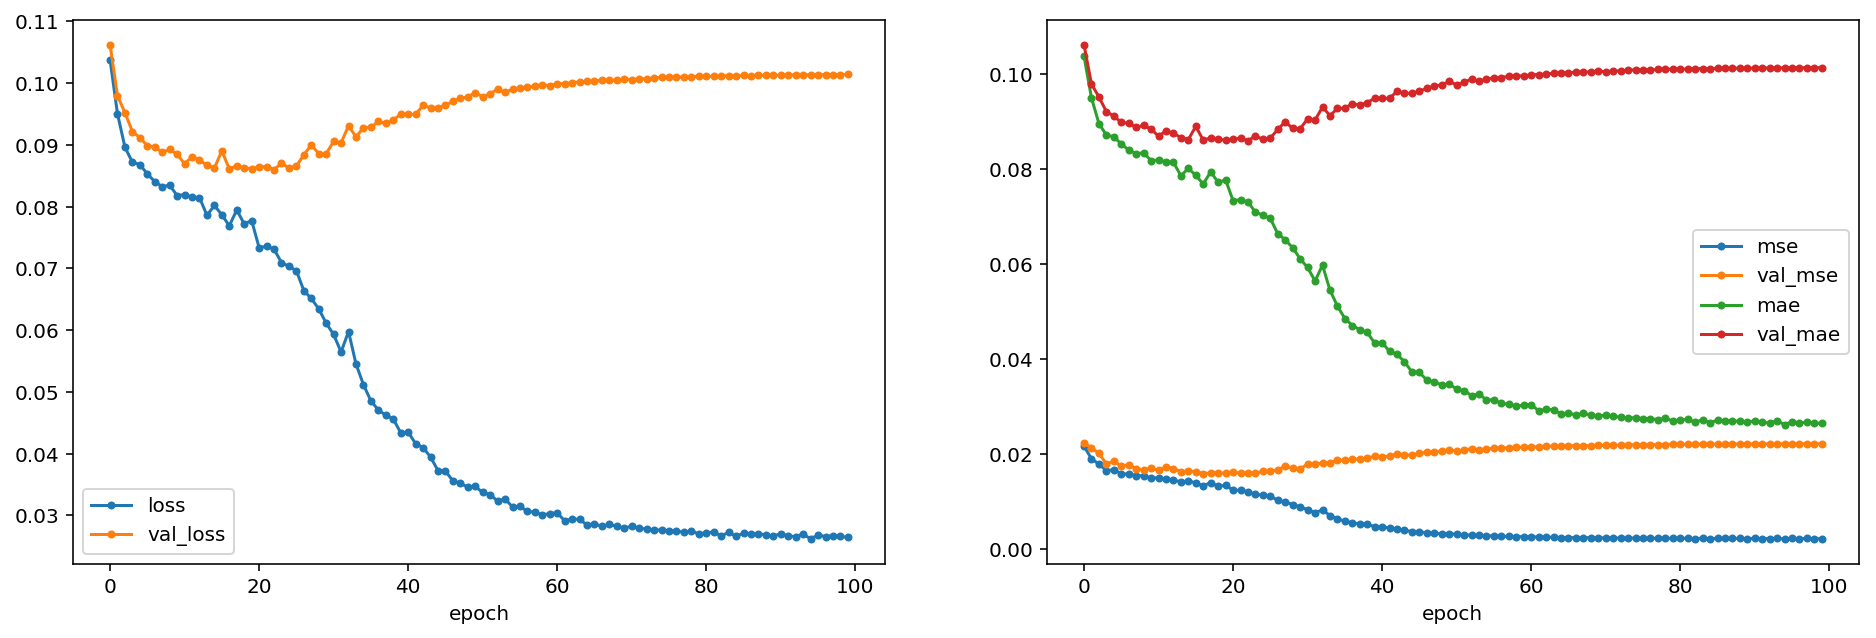

In [15]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss'],['mse','val_mse','mae','val_mae']);

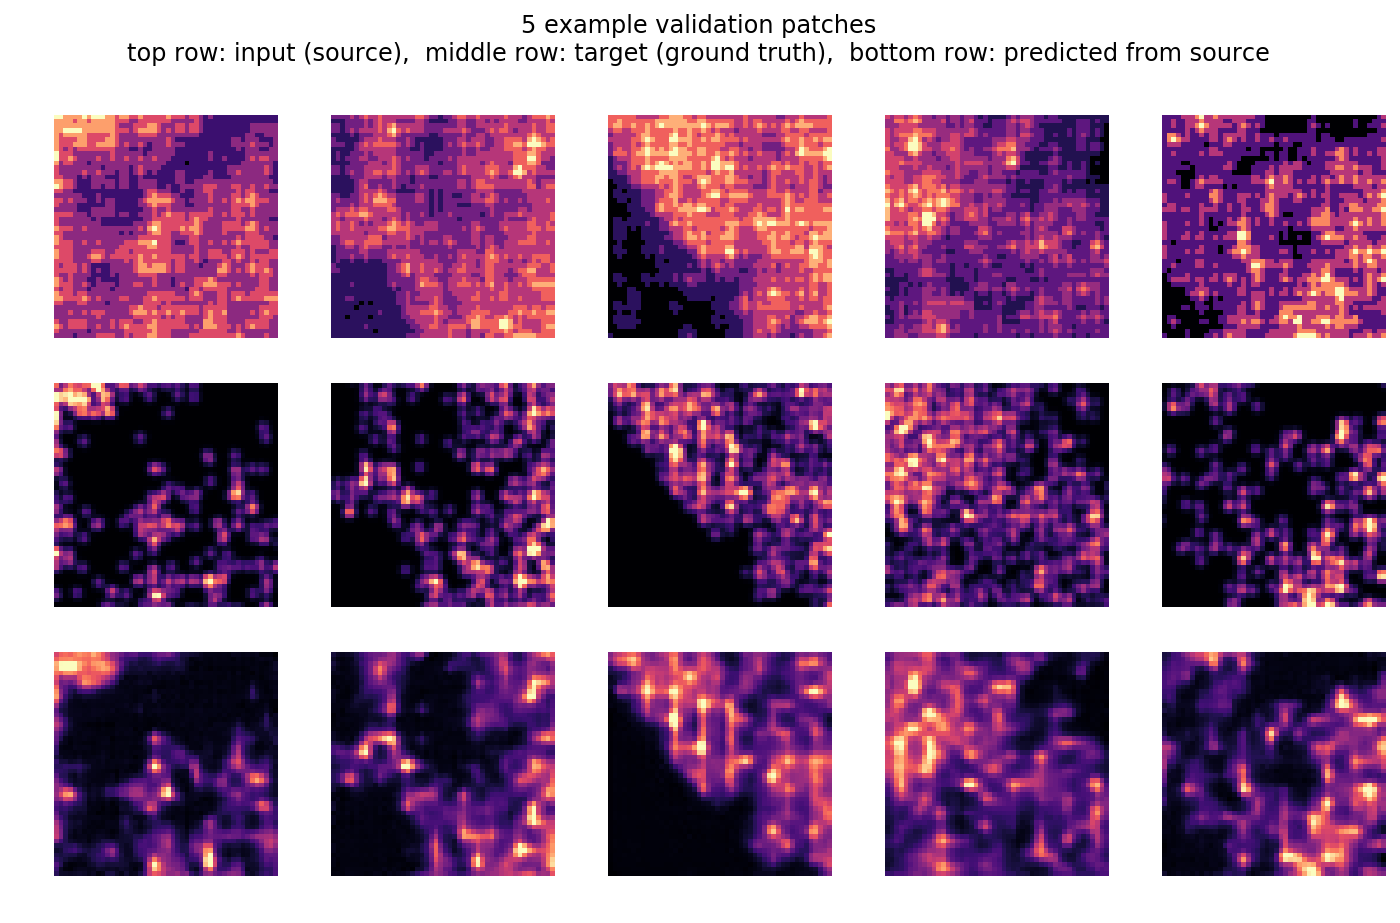

In [17]:
plt.figure(figsize=(12,7))
_P = model.keras_model.predict(X_val[:5])
if config.probabilistic:
    _P = _P[...,:(_P.shape[-1]//2)]
plot_some(X_val[:5],Y_val[:5],_P,pmax=99.5)
plt.suptitle('5 example validation patches\n'      
             'top row: input (source),  '          
             'middle row: target (ground truth),  '
             'bottom row: predicted from source');

In [18]:
model.export_TF()

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmp0fj84ftu\model\saved_model.pb

Model exported in TensorFlow's SavedModel format:
C:\Users\Administrator\Documents\REVORGDATA\paper\extractionScripts\deeplearn_analysis\projection\models\my_model\TF_SavedModel.zip


<hr style="height:2px;">

# STEP 3: PREDICTION AND SAVE FINAL RECONSTRUCTION

We first need to create a `RawData` object, which defines how to get the pairs of low/high SNR images and the semantics of each axis (e.g. which one is considered a color channel, etc.).



In [19]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from csbdeep.utils import Path, download_and_extract_zip_file, plot_some
from csbdeep.io import save_tiff_imagej_compatible
from csbdeep.models import ProjectionCARE

input  image size = (21, 768, 768)
output image size = (768, 768)
source image size = (21, 768, 768)
source image axes = ZYX
target image size = (768, 768)


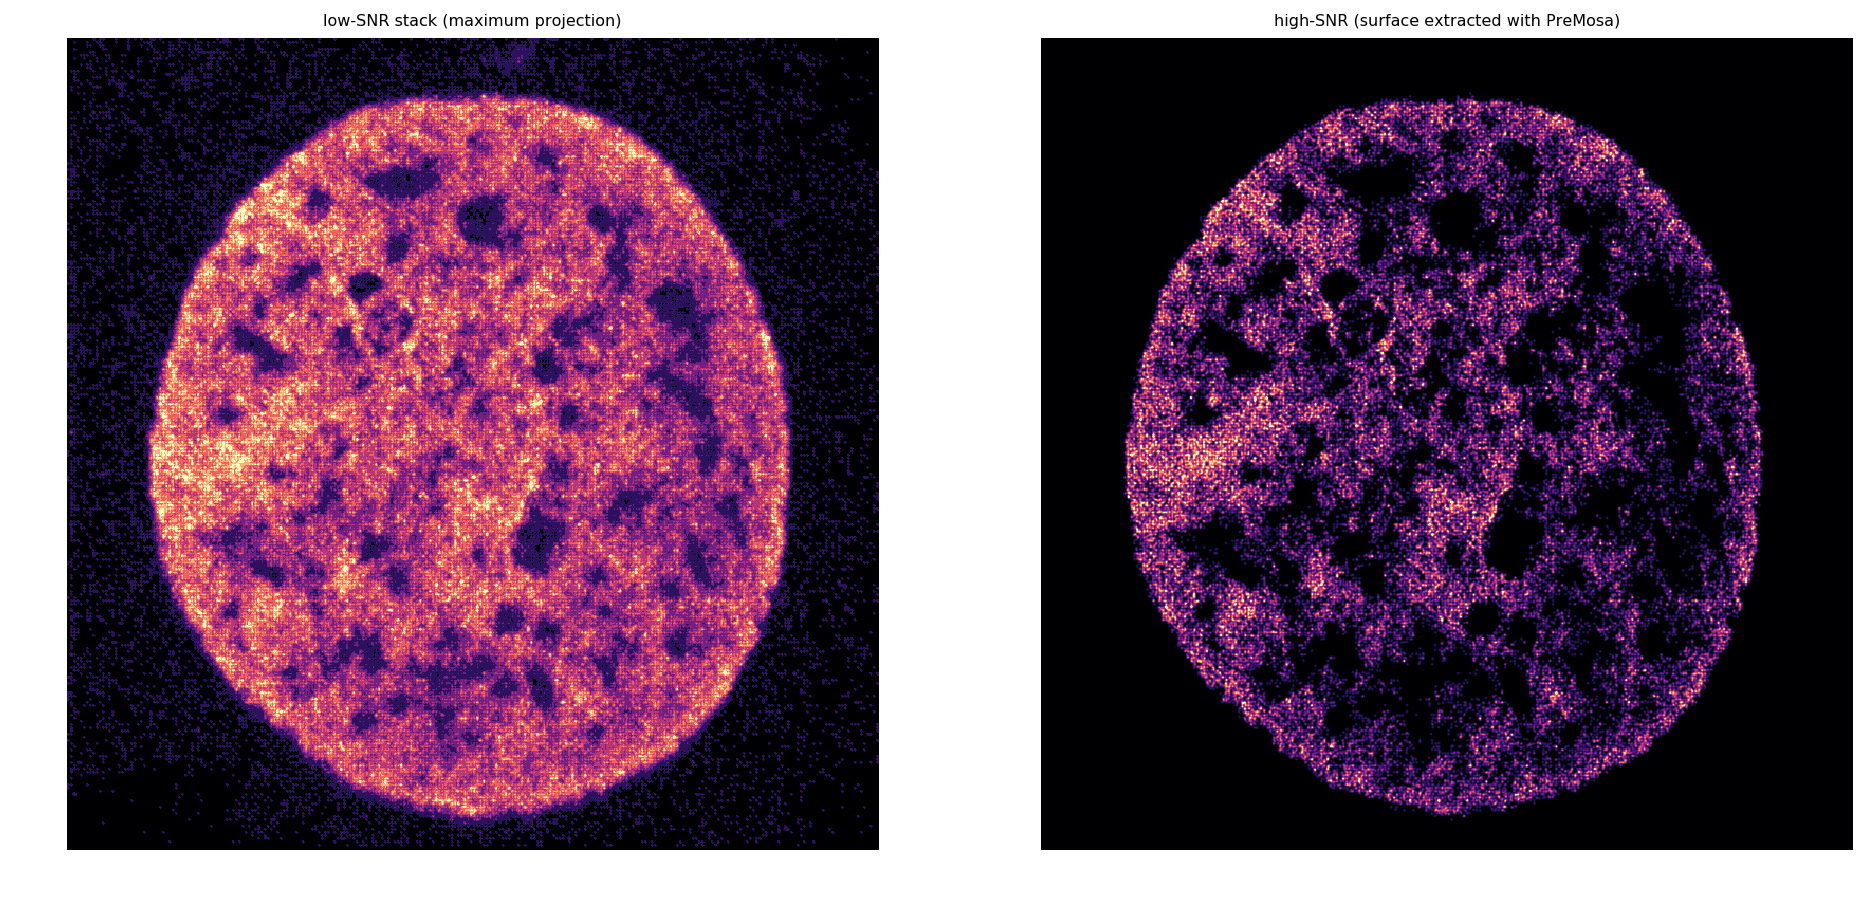

In [20]:
#y = imread('data/retinasrb/s5-c05long-26slices-fluo.tiff')
#x = imread('data/retinab/s5-c05long-26slices-fluo.tif')

y = imread('data/retinasrb/imbrducell.tif')
x = imread('data/retinab/imbrducell.tif')
print('input  image size =', x.shape)
print('output image size =', y.shape)

axes = 'ZYX'
print('source image size =', x.shape)
print('source image axes =', axes)
print('target image size =', y.shape)

plt.figure(figsize=(16,10))
plot_some(np.stack([x,np.broadcast_to(y,x.shape)]),
          title_list=[['low-SNR stack (maximum projection)','high-SNR (surface extracted with PreMosa)']], 
          pmin=2,pmax=99.8);

In [21]:
model = ProjectionCARE(config=None, name='my_model', basedir='models')

Loading network weights from 'weights_best.h5'.


In [22]:
%%time
restored = model.predict(x, axes)

Wall time: 34.7 s


In [23]:
Path('results').mkdir(exist_ok=True)
axes_restored = axes.replace(model.proj_params.axis,'')
save_tiff_imagej_compatible('results/%s_sriondeep_chromatinbrdubyidutrainF.tif' % model.name, restored, axes_restored)

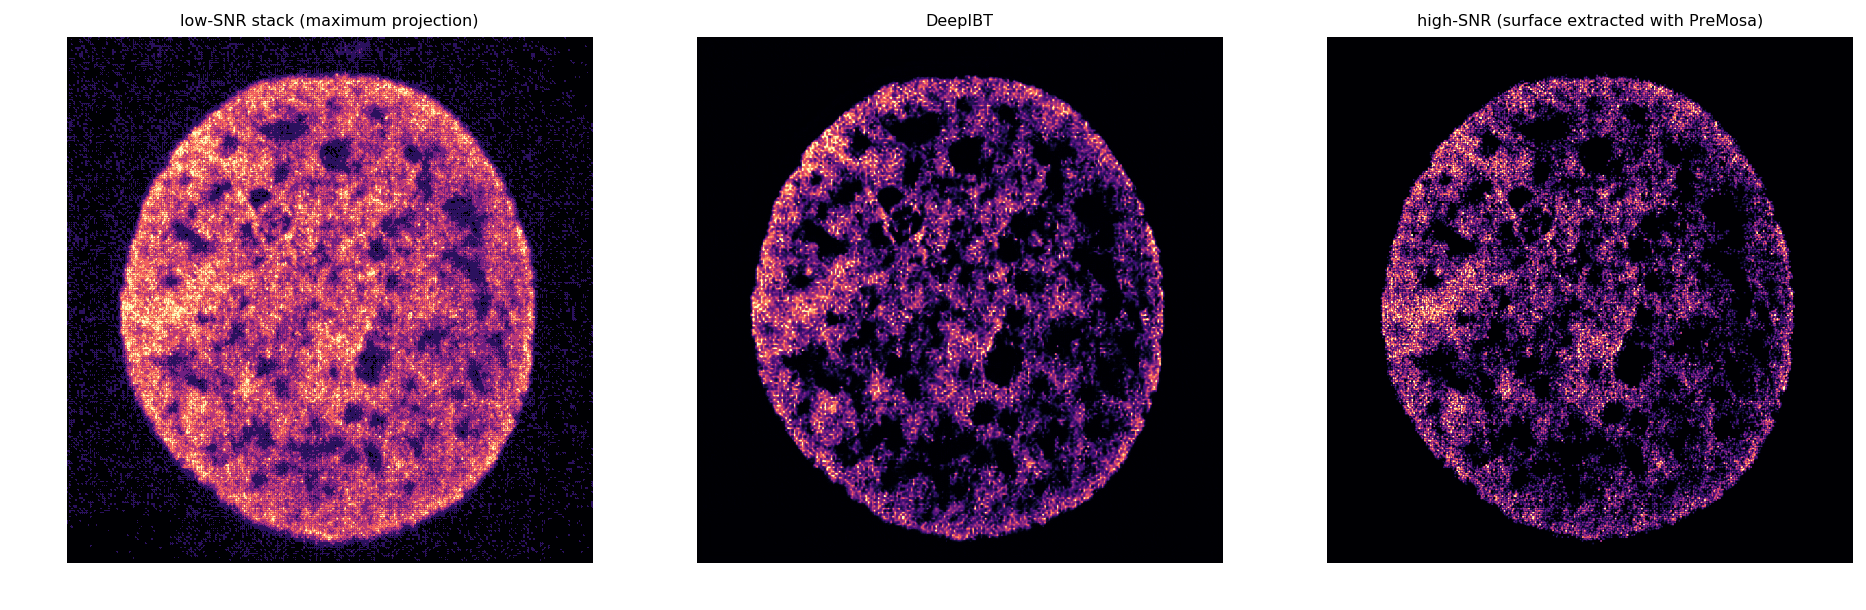

In [24]:
plt.figure(figsize=(16,10))
plot_some(np.stack([x,np.broadcast_to(restored,x.shape),np.broadcast_to(y,x.shape)]),
          title_list=[['low-SNR stack (maximum projection)','DeepIBT','high-SNR (surface extracted with PreMosa)']], 
          pmin=2,pmax=99.8);

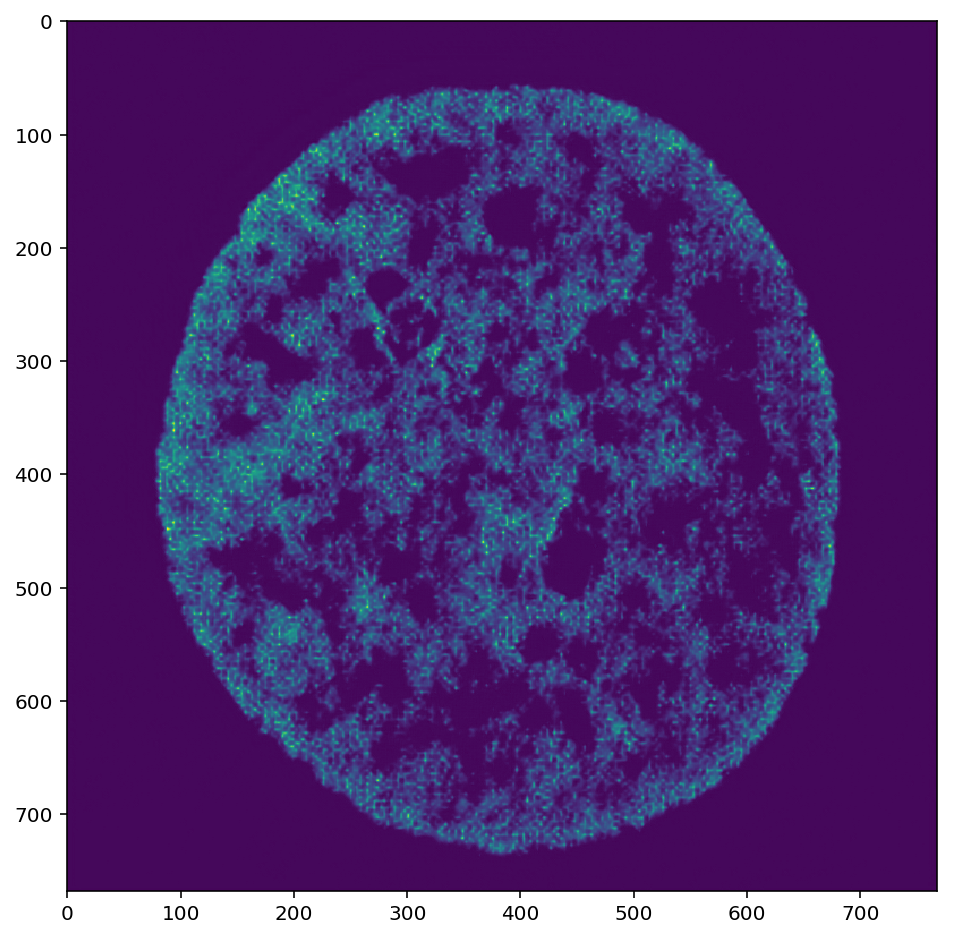

In [25]:
from PIL import Image
import matplotlib
import matplotlib.pyplot as pyplot

im = Image.open('results/my_model_sriondeep_chromatinbrdubyidutrainF.tif')


#im = im.crop((160,305,340,485))
image=im
im = 255*(image - np.min(image))/np.ptp(image).astype(int)


#im = im.crop((195,310,375,490))
#im.save('sriondeep_nanotagfluobysitrainFsmall.tif')
matplotlib.image.imsave('sriondeep_chromatinbrdubyidutrainFsmallgray.tif', im)


img = im
fig=pyplot.figure(figsize = (8, 8))

pyplot.imshow(img)


pyplot.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


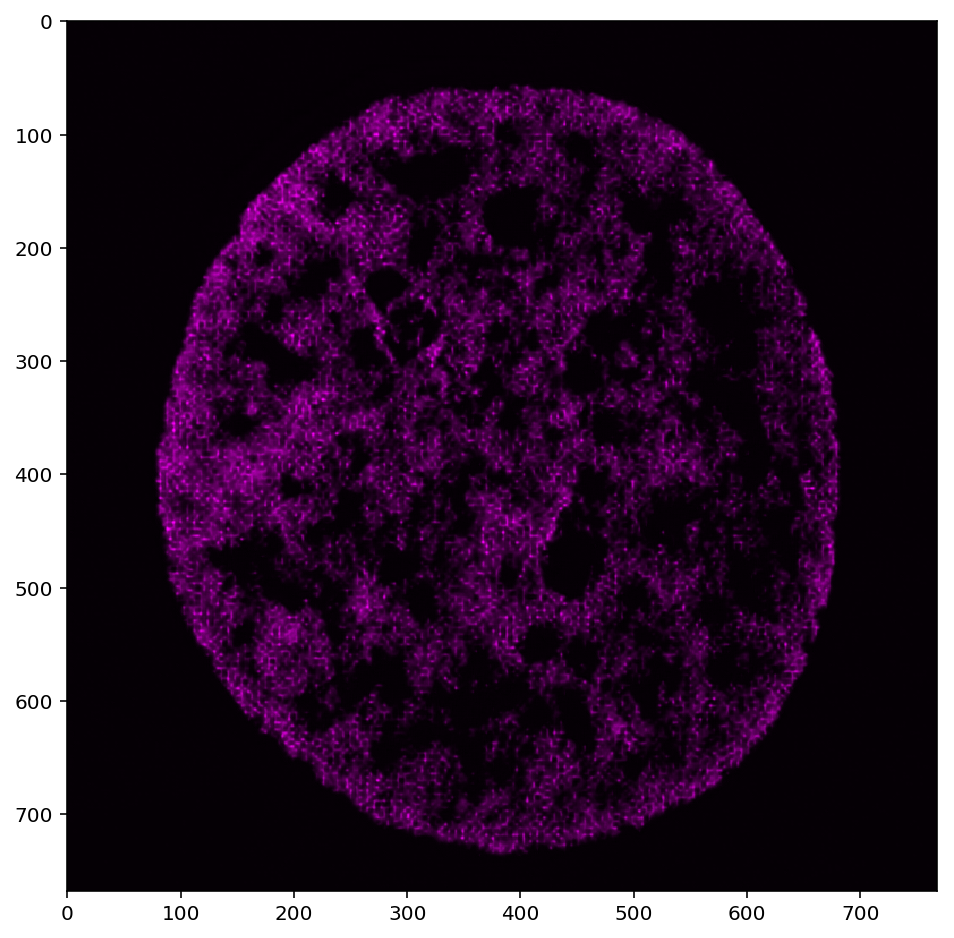

(768, 768, 3)


In [26]:
from PIL import Image
import numpy as np

color=(0, 255, 0)
im = np.array(img)
#r, g, b, a = np.rollaxis(x, axis=-1)
#r[a == 0] = color[0]

#im=r


dim = np.zeros((768,768))

#select blue color for the image display and save
R = np.stack((im,dim, im), axis=2)/255;

fig=pyplot.figure(figsize = (8, 8))
pyplot.imshow(R)
pyplot.show()
print(R.shape)



import matplotlib

matplotlib.image.imsave('sriondeep_chromatinbrdubyidutrainFsmallcolor.tif', R)



rgb = np.zeros((255, 255, 3), dtype=np.uint8)
rgb[..., 0] = np.arange(255)
rgb[..., 1] = 55
rgb[..., 2] =  1- np.arange(255)